In [18]:
## Importing libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [19]:
## Importing data 
store_sales = pd.read_csv("train.csv", 
                        usecols=['id','date','store_nbr', 'family', 'onpromotion','sales'],
                        dtype={
                            'id':'int',
                            'store_nbr': 'category',
                            'family': 'category',
                            'onpromotion': 'uint32',
                            'sales': 'float32',
                        },
                        parse_dates=['date'],
                        infer_datetime_format=True,
                    )
store_sales['date'] = store_sales['date'].dt.to_period("D")

test_df = pd.read_csv("test.csv", 
                        usecols=['id', 'date','store_nbr', 'family', 'onpromotion'],
                        dtype={
                            'id':'int',
                            'store_nbr': 'category',
                            'family': 'category',
                            'sales': 'float32',
                            'onpromotion': 'uint32',
                        },
                        parse_dates=['date'],
                        infer_datetime_format=True,
                    )
test_df['date'] = test_df['date'].dt.to_period("D")

stores = pd.read_csv("stores.csv",
                      dtype={'store_nbr': 'category',
                              'city':'string',
                              'state': 'string',
                              'type': 'category',
                              'cluster':'category'
                             }                       
                         )

holidays = pd.read_csv("holidays_events.csv",parse_dates = ['date'], infer_datetime_format = True)

transactions = pd.read_csv("transactions.csv",
                           dtype = {'store_nbr':'category',
                                    'transactions': 'float32'
                                   },
                               parse_dates = ['date'], infer_datetime_format = True)
transactions['date'] = transactions['date'].dt.to_period("D")

For simplicity sake, we limit our dataset to the Grocery I category. The goal is to provide forecasts accross all 54 stores in the Grocery I Category

In [20]:
grocery_sales = store_sales[store_sales['family'] == 'GROCERY I'].copy()

## SARIMA MODEL 

The first model I will experience is the SARIMA (Seasonal AutoRegressive Moving Average) model. This model includes seasonal component to the traditional ARIMA model. This model will break down the time series into:
- **Autogressive component :**  value at each point is dependent of past values  
- **Differencing component (y$^{t} - y$$^{t-n}$ ) :**  differentiate a data point with a value  n-steps in the past to make the data stationary
- **Moving Average component :** value at each point in time is function of past "error" terms

In [21]:
## Develop the SARIMA MODEL FOR store 10
grocery_sales_10 = grocery_sales[grocery_sales['store_nbr'] == '10']
grocery_sales_10 = grocery_sales_10.set_index('date')

<AxesSubplot: title={'center': 'Grocery sales at store 10'}, xlabel='date'>

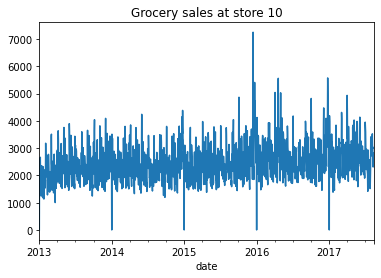

In [23]:
## Visualizing the sales data
grocery_sales_10.sales.plot(title = 'Grocery sales at store 10')

<AxesSubplot: title={'center': 'Moving Average Sales at store 10'}>

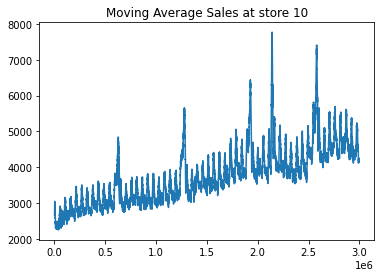

In [25]:
## Visualizing the trend to verify that data is stationary
sales_ma = grocery_sales.sales.rolling(window = 365, center = True).mean()
sales_ma.plot(title = "Moving Average Sales at store 10")

<AxesSubplot: xlabel='date'>

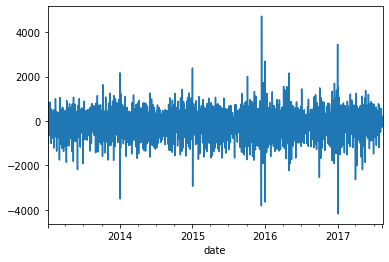

In [26]:
## Differentiating to make sales data stationary
grocery_sales_10['lag1'] = grocery_sales_10['sales'].shift(1)
grocery_sales_10['diff_sales'] = grocery_sales_10['lag1'] - grocery_sales_10['sales']
grocery_sales_10 = grocery_sales_10.dropna()
grocery_sales_10['diff_sales'].plot()

Now the data appears to be stationary. Let's visualize to differentiated moving sales average

<AxesSubplot: title={'center': 'Moving average differentiate sales'}, xlabel='date'>

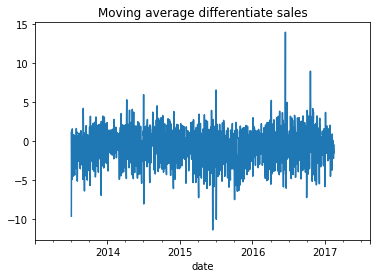

In [28]:
## Visualizing the trend to verify that data is stationary
sales_ma = grocery_sales_10['diff_sales'].rolling(window = 365, center = True).mean()
sales_ma.plot(title= "Moving average differentiate sales")

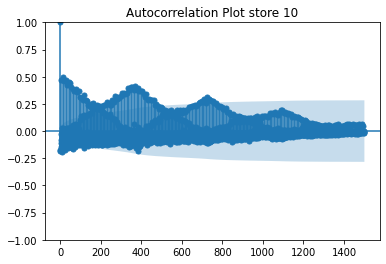

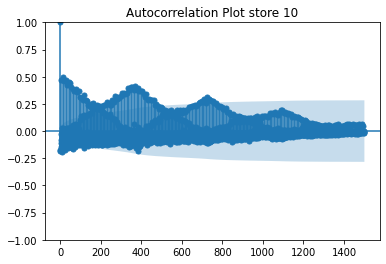

In [29]:
##Plotting ACF dand PACF to fit the SARIMA model
## ACF 
plot_acf(grocery_sales_10['diff_sales'],
    ax=None,
    lags=1500,
    alpha=0.05,
    use_vlines=True,
    title='Autocorrelation Plot store 10, lags = 1500',
    zero=True,
)

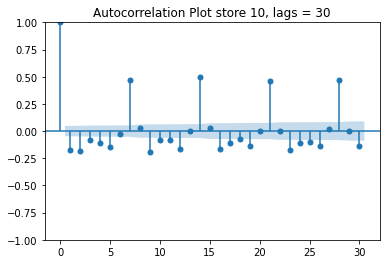

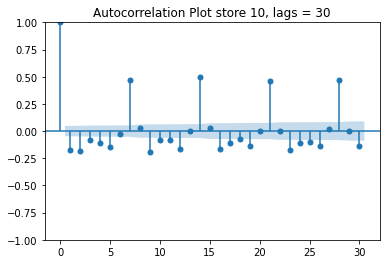

In [31]:
plot_acf(grocery_sales_10['diff_sales'],
    ax=None,
    lags = 30,
    alpha=0.05,
    use_vlines=True,
    title='Autocorrelation Plot store 10, lags = 30',
    zero=True,
)

In first approximation, we see the store data presents a strongly semi_annual  and weekly seasonal components. 
As our dataset presents 2 seasonality components, which seasonality component should we favor ?

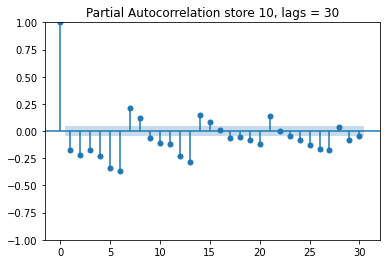

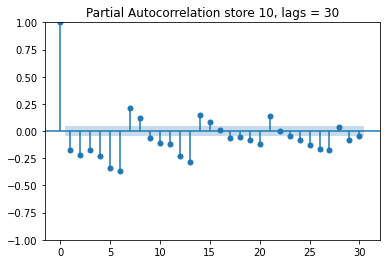

In [33]:
## PACF
plot_pacf(grocery_sales_10['diff_sales'],
    ax=None,
    lags=30,
    alpha=0.05,
    method=None,
    use_vlines=True,
    title='Partial Autocorrelation store 10, lags = 30',
    zero=True,
    vlines_kwargs=None)

## Choice of parameters:
 - Regular components : p = 1 , d=1 , q = 6
 - Seasonal components : P= 1  ,D=1, Q =0, S = 7 

In [40]:
## Split  the data 
train_idx,test_idx = train_test_split(grocery_sales_10.index, train_size = .95, test_size = .05, random_state = 42, shuffle = False)

## Creating the features of SARIMA model
y_train = grocery_sales_10['sales'][:len(train_idx)]
y_test = grocery_sales_10['sales'][len(train_idx):]

## Fitting the model
predictions = list()
history = list(y_train.copy())

for t in range(0,len(test_idx)):
    ## Call the ARIMA MODEL 
    model = ARIMA(
         history,
         order=(1,1,6),
         seasonal_order=(1,1,0,7))
    
    # fit to newly predicted value 
    model_fit = model.fit()
    
    ## forecast one value ahead 
    y_forecast = model_fit.forecast(1)
       
    ## append result to history series
    predictions.append(y_forecast[0])
    obs = y_test[t]
    history.append(obs)

# evaluate forecasts
rmse = math.sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 449.858


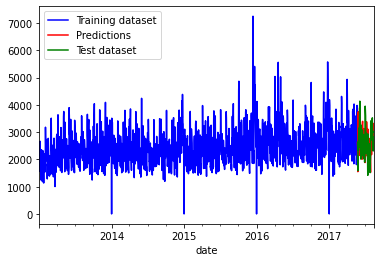

In [46]:
## Visualize the predictions
y_train_1 = pd.Series(y_train,index =grocery_sales_10.index[:len(train_idx)] )
y_test_1 = pd.Series(y_test,index =grocery_sales_10.index[len(train_idx):])
prediction_1 = pd.Series(predictions,index =grocery_sales_10.index[len(train_idx):])

fig,ax = plt.subplots()
y_train_1.plot(color = 'blue',label = 'Training dataset')
prediction_1.plot(color = 'red', label = 'Predictions')
y_test_1.plot(color = 'green', label = 'Test dataset')
ax.legend()


Because we can't manually fit all 54 models for the different stores, we will use the auto_arima module to get the parameters for the different stores.


In [53]:
from pmdarima.arima import auto_arima
model = auto_arima(y_train, start_p = 1, d =1, start_q = 1,
          max_p = 5, max_q =7,
          start_Q = 0, start_P = 1, D = 1,
          max_P = 5, max_Q = 25,
          seasonal = True, error_action = 'warn', trace = True,
          suppress_warnings = True, stepwise = True, 
          random_state= 42,n_fits = 200)

## Summary of the model
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25440.755, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25392.217, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25274.544, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25438.755, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=25272.683, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=24943.245, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=24922.994, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=24922.435, Time=0.48 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=24920.550, Time=0.34 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=24922.2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1598
Model:               SARIMAX(0, 1, 3)   Log Likelihood              -12456.275
Date:                Tue, 28 Mar 2023   AIC                          24920.550
Time:                        15:54:06   BIC                          24942.054
Sample:                    01-02-2013   HQIC                         24928.536
                         - 05-22-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4870      0.017    -29.073      0.000      -0.520      -0.454
ma.L2         -0.3623      0.026    -14.185      0.000      -0.412      -0.312
ma.L3         -0.1329      0.024     -5.459      0.000      -0.181      -0.085
sigma2       3.48e+05   7535.335     46.178      0.000    3.33e+05    3.63e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1177.51
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
order = model.get_params()['order']
seasonal_order  = model.get_params()['seasonal_order']

In [52]:
## Fitting the model
predictions = list()
history = list(y_train.copy())

for t in range(0,len(test_idx)):
    ## Call the ARIMA MODEL 
    model = ARIMA(
         history,
         order=order,
         seasonal_order= seasonal_order)
    
    # fit to newly predicted value 
    model_fit = model.fit()
    
    ## forecast one value ahead 
    y_forecast = model_fit.forecast(1)
       
    ## append result to history series
    predictions.append(y_forecast[0])
    obs = y_test[t]
    history.append(obs)

# evaluate forecasts
rmse = math.sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 457.607


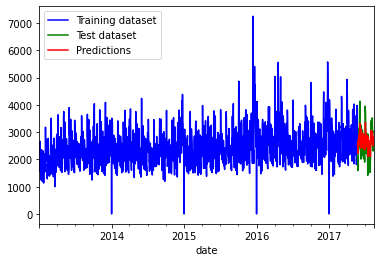

In [57]:
## Visualize the predictions
y_train_1 = pd.Series(y_train,index =grocery_sales_10.index[:len(train_idx)] )
y_test_1 = pd.Series(y_test,index =grocery_sales_10.index[len(train_idx):])
prediction_1 = pd.Series(predictions,index =grocery_sales_10.index[len(train_idx):])
fig,ax = plt.subplots()
y_train_1.plot(color = 'blue',label = 'Training dataset')
y_test_1.plot(color = 'green', label = 'Test dataset')
prediction_1.plot(color = 'red', label = 'Predictions')
ax.legend()

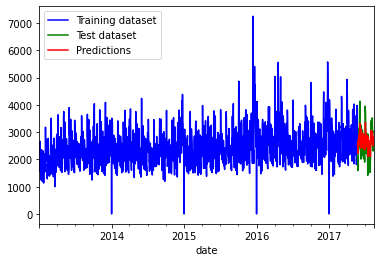

In [58]:
y_train_1.plot(color = 'blue', label = 'Training dataset').legend()
y_test_1.plot(color = 'green', label = 'Test dataset').legend()
prediction_1.plot(color = 'red', label = 'Predictions').legend()


In [61]:
## Automate the process:

grocery_sales = grocery_sales.set_index('date')

def prepare_data(df, store_nbr):
    temp = df[df['store_nbr'] == store_nbr]
    temp['lag1'] = temp['sales'].shift(1)
    temp['shifted_sales'] = temp['sales'] - temp['lag1']
    temp = temp.dropna()
    
    ## Split  the data 
    train_idx,test_idx = train_test_split(grocery_sales_10.index, train_size = .95, test_size = .05, random_state = 42, shuffle = False)

    ## Creating the features of SARIMA model
    y_train = temp['sales'][:len(train_idx)]
    y_test = temp['sales'][len(train_idx):]

    return y_train, y_test


def fit_model(y_train, y_test):
    
    ## Auto fit the SARIMA model
    model = auto_arima(y_train, start_p = 1, d =1, start_q = 0,
          max_p = 7, max_q =7,
          start_Q = 0, start_P = 1, D = 1,
          max_P = 7, max_Q = 7,
          seasonal = True, error_action = 'warn', trace = True,
          suppress_warnings = True, stepwise = True, 
          random_state= 42,n_fits = 150)

    ## Collect the seasonal and order parameters
    order = model.get_params()['order']
    seasonal_order  = model.get_params()['seasonal_order']
    
    ## Fitting the model
    predictions = list()
    history = list(y_train.copy())

    for t in range(0,len(test_idx)):
        ## Call the ARIMA MODEL 
        model = ARIMA(
                    history,
                    order=order,
                    seasonal_order=seasonal_order)

        # fit to newly predicted value 
        model_fit = model.fit()

        ## forecast one value ahead 
        y_forecast = model_fit.forecast(1)

        ## append result to history series
        predictions.append(y_forecast[0])
        obs = y_test[t]
        history.append(obs)

    # evaluate forecasts
    rmse = math.sqrt(mean_squared_error(y_test, predictions))
    print('Test RMSE: %.3f' % rmse)
    
    ## Visualize the predictions
    y_train_1 = pd.Series(y_train,index =grocery_sales_10.index[:len(train_idx)] )
    y_test_1 = pd.Series(y_test,index =grocery_sales_10.index[len(train_idx):])
    prediction_1 = pd.Series(predictions,index =grocery_sales_10.index[len(train_idx):])
    
    y_train_1.plot(color = 'blue', label = 'Training dataset').legend()
    y_test_1.plot(color = 'green', label = 'Test dataset').legend()
    prediction_1.plot(color = 'red', label = 'Predictions').legend()
    
    return prediction_1



<ipython-input-61-d89a2b38608c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['lag1'] = temp['sales'].shift(1)
<ipython-input-61-d89a2b38608c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['shifted_sales'] = temp['sales'] - temp['lag1']


Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25564.002, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25928.379, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25250.747, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25926.380, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25186.398, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25169.421, Time=0.69 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=25505.832, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=25445.768, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=25169.412, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=25185.654, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2

C:\Users\Agnes\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Agnes\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Agnes\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Agnes\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Agnes\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

Test RMSE: 368.467


date
2017-05-23    3015.894982
2017-05-24    3221.359740
2017-05-25    2983.541089
2017-05-26    2771.297515
2017-05-27    3258.366305
                 ...     
2017-08-11    2654.255067
2017-08-12    2820.479367
2017-08-13    2419.484535
2017-08-14    2712.433724
2017-08-15    2690.516499
Freq: D, Length: 85, dtype: float64

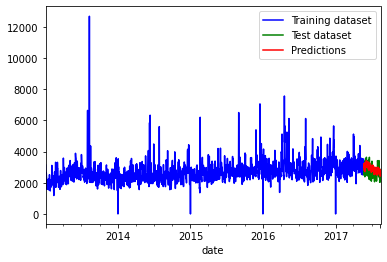

In [62]:
y_train,y_test = prepare_data(grocery_sales,'15')
fit_model(y_train, y_test)

In [63]:
len(y_test)

85